# Using Neural Network Formulations in OMLT

In this notebook we show how OMLT can be used to build different optimization formulations of neural networks within Pyomo. It specifically demonstrates the following examples:<br>
1.) A neural network with smooth sigmoid activation functions represented using full-space and reduced-space formulations <br>
2.) A neural network with non-smooth ReLU activation functions represented using complementarity and mixed integer formulations <br>
3.) A neural network with mixed ReLU and sigmoid activation functions represented using complementarity (for ReLU) and full-space (for sigmoid) formulations <br>
<br>
After building the OMLT formulations, we minimize each representation of the function and compare the results.

## Library Setup
This notebook assumes you have a working Tensorflow environment in addition to necessary Python packages described here. We use Keras to train neural networks of interest for our example which requires the Python Tensorflow package. The neural networks are then formulated in Pyomo using OMLT which therefore requires working Pyomo and OMLT installations.

The required Python libraries used this notebook are as follows: <br>
- `pandas`: used for data import and management <br>
- `matplotlib`: used for plotting the results in this example
- `tensorflow`: the machine learning language we use to train our neural network
- `pyomo`: the algebraic modeling language for Python, it is used to define the optimization model passed to the solver
- `omlt`: The package this notebook demonstates. OMLT can formulate machine learning models (such as neural networks) within Pyomo

In [23]:
#Start by importing the following libraries
#data manipulation and plotting
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', size=24)
plt.rc('axes', titlesize=24)

#tensorflow objects
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

#pyomo for optimization
import pyomo.environ as pyo

#omlt for interfacing our neural network with pyomo
from omlt import OmltBlock
from omlt.neuralnet import NetworkDefinition, FullSpaceNNFormulation, \
FullSpaceSmoothNNFormulation, ReducedSpaceSmoothNNFormulation, ReluBigMFormulation,\
ReluComplementarityFormulation
from omlt.neuralnet.activations import ComplementarityReLUActivation
from omlt.io import keras_reader
import omlt

## Import the Data

We begin by training neural networks that learn from data given the following imported dataframe. In practice, this data could represent the output of a simulation, real sensor measurements, or some other external data source. The data contains a single input `x` and a single output `y` and contains 10,000 total samples

In [6]:
df = pd.read_csv("../data/sin_quadratic.csv",index_col=[0]);

The data we use for training is plotted below (on the left figure). We also scale the training data to a mean of zero with unit standard deviation. The scaled inputs and outputs are added to the dataframe and plotted next to the original data values (on the right).

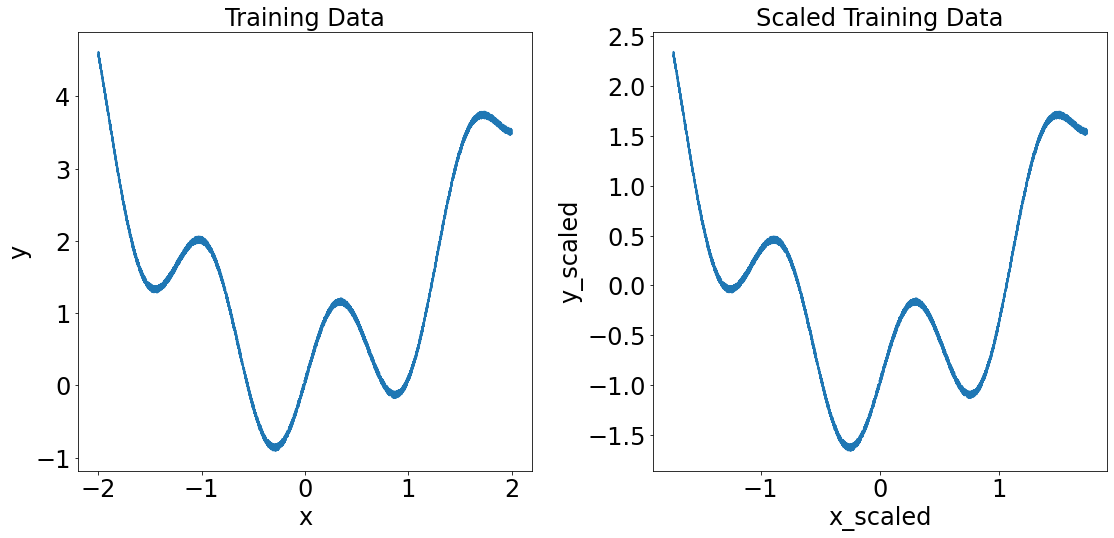

In [7]:
#retrieve input 'x' and output 'y' from the dataframe
x = df["x"]
y = df["y"]

#calculate mean and standard deviation, add scaled 'x' and scaled 'y' to the dataframe
mean_data = df.mean(axis=0)
std_data = df.std(axis=0)
df["x_scaled"] = (df['x'] - mean_data['x']) / std_data['x']
df["y_scaled"] = (df['y'] - mean_data['y']) / std_data['y']

#create plots for unscaled and scaled data
f, (ax1, ax2) = plt.subplots(1, 2,figsize = (16,8))

ax1.plot(x, y)
ax1.set_xlabel("x")
ax1.set_ylabel("y");
ax1.set_title("Training Data")

ax2.plot(df["x_scaled"], df["y_scaled"])
ax2.set_xlabel("x_scaled")
ax2.set_ylabel("y_scaled");
ax2.set_title("Scaled Training Data")

plt.tight_layout()

## Train the Neural Networks
After importing the dataset we use Tensorflow (with Keras) to train three neural network models. Each neural network contains 2 layers with 100 nodes per layer with a single output layer. <br>
1.) The first network (`nn1`) uses sigmoid activation functions for both layers.<br>
2.) The second network (`nn2`) uses ReLU activations<br>
3.) The last network (`nn3`) mixes ReLU and sigmoid activation functions. The first layer is sigmoid, the second layer is ReLU. <br>
We use the ADAM optimizer and train the first two neural networks for 50 epochs. We train `nn3` for 150 epochs since we observe difficulty obtaining a good fit with the mixed network.

In [13]:
#sigmoid neural network
nn1 = Sequential(name='sin_wave_sigmoid')
nn1.add(Input(1))
nn1.add(Dense(50, activation='sigmoid'))
nn1.add(Dense(50, activation='sigmoid'))
nn1.add(Dense(1))
nn1.compile(optimizer=Adam(), loss='mse')

#relu neural network
nn2 = Sequential(name='sin_wave_relu')
nn2.add(Input(1))
nn2.add(Dense(50, activation='relu'))
nn2.add(Dense(50, activation='relu'))
nn2.add(Dense(1))
nn2.compile(optimizer=Adam(), loss='mse')

#mixed neural network
nn3 = Sequential(name='sin_wave_mixed')
nn3.add(Input(1))
nn3.add(Dense(50, activation='sigmoid'))
nn3.add(Dense(50, activation='relu'))
nn3.add(Dense(1))
nn3.compile(optimizer=Adam(), loss='mse')

In [14]:
#train all three neural networks
history1 = nn1.fit(x=df['x_scaled'], y=df['y_scaled'],verbose=1, epochs=75)
history2 = nn2.fit(x=df['x_scaled'], y=df['y_scaled'],verbose=1, epochs=75)
history3 = nn3.fit(x=df['x_scaled'], y=df['y_scaled'],verbose=1, epochs=150)

Epoch 1/75
313/313 [==============================] - 1s 2ms/step - loss: 1.0087
Epoch 2/75
313/313 [==============================] - 1s 2ms/step - loss: 0.9942
Epoch 3/75
313/313 [==============================] - 1s 2ms/step - loss: 0.9743
Epoch 4/75
313/313 [==============================] - 1s 2ms/step - loss: 0.8720
Epoch 5/75
313/313 [==============================] - 1s 2ms/step - loss: 0.5027
Epoch 6/75
313/313 [==============================] - 0s 2ms/step - loss: 0.2857
Epoch 7/75
313/313 [==============================] - 1s 2ms/step - loss: 0.2441
Epoch 8/75
313/313 [==============================] - 0s 2ms/step - loss: 0.2293
Epoch 9/75
313/313 [==============================] - 1s 2ms/step - loss: 0.2192
Epoch 10/75
313/313 [==============================] - 0s 2ms/step - loss: 0.2119
Epoch 11/75
313/313 [==============================] - 1s 2ms/step - loss: 0.2007
Epoch 12/75
313/313 [==============================] - 1s 2ms/step - loss: 0.1884
Epoch 13/75
313/313 [====

313/313 [==============================] - 0s 1ms/step - loss: 0.0277
Epoch 26/75
313/313 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 27/75
313/313 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 28/75
313/313 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 29/75
313/313 [==============================] - 0s 1ms/step - loss: 0.0032
Epoch 30/75
313/313 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 31/75
313/313 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 32/75
313/313 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 33/75
313/313 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 34/75
313/313 [==============================] - 0s 2ms/step - loss: 9.8536e-04
Epoch 35/75
313/313 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 36/75
313/313 [==============================] - 0s 2ms/step - loss: 9.5461e-04
Epoch 37/75
313/313 

313/313 [==============================] - 1s 3ms/step - loss: 0.0218
Epoch 48/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0222
Epoch 49/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0214
Epoch 50/150
313/313 [==============================] - 0s 2ms/step - loss: 0.0216
Epoch 51/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0202
Epoch 52/150
313/313 [==============================] - 1s 3ms/step - loss: 0.0205
Epoch 53/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0206
Epoch 54/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0197
Epoch 55/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0194
Epoch 56/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0194
Epoch 57/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0187
Epoch 58/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0190
Epoch 59/150
313/

313/313 [==============================] - 1s 2ms/step - loss: 0.0058
Epoch 145/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0054
Epoch 146/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0059
Epoch 147/150
313/313 [==============================] - 1s 2ms/step - loss: 0.0055
Epoch 148/150
313/313 [==============================] - 1s 3ms/step - loss: 0.0055
Epoch 149/150
313/313 [==============================] - 1s 3ms/step - loss: 0.0053
Epoch 150/150
313/313 [==============================] - 1s 4ms/step - loss: 0.0050


## Check the predictions
Before we formulate our trained neural networks in OMLT, we check to see that they adequately represent the data. While we would normally use some accuracy measure, we suffice with a visual plot of the fits.

In [15]:
#note: we calculate the unscaled output for each neural network to check the predictions
#nn1
y_predict_scaled_sigmoid = nn1.predict(x=df['x_scaled'])
y_predict_sigmoid = y_predict_scaled_sigmoid*(std_data['y']) + mean_data['y']

#nn2
y_predict_scaled_relu = nn2.predict(x=df['x_scaled'])
y_predict_relu = y_predict_scaled_relu*(std_data['y']) + mean_data['y']

#nn3
y_predict_scaled_mixed = nn3.predict(x=df['x_scaled'])
y_predict_mixed = y_predict_scaled_mixed*(std_data['y']) + mean_data['y']

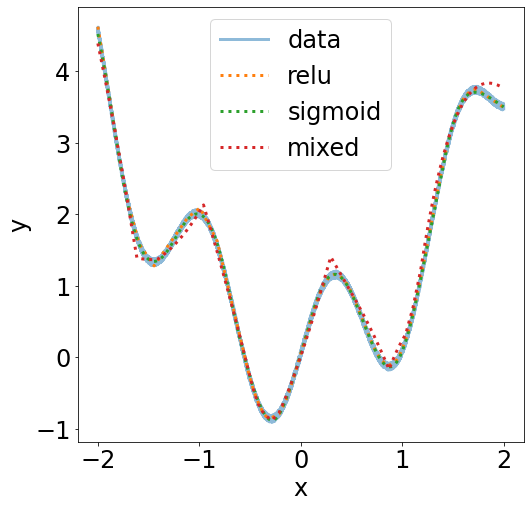

In [16]:
#create a single plot with the original data and each neural network's predictions
fig,ax = plt.subplots(1,figsize = (8,8))
ax.plot(x,y,linewidth = 3.0,label = "data", alpha = 0.5)
ax.plot(x,y_predict_relu,linewidth = 3.0,linestyle="dotted",label = "relu")
ax.plot(x,y_predict_sigmoid,linewidth = 3.0,linestyle="dotted",label = "sigmoid")
ax.plot(x,y_predict_mixed,linewidth = 3.0,linestyle="dotted",label = "mixed")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

## Formulating Neural Networks with OMLT
We now show how OMLT can formulate neural networks within Pyomo. We specifically show how to specify and build different neural network optimization formulations and how to connect them with a broader Pyomo model. In these examples we use Pyomo solvers to find the input that minimizes each neural network output.
<br><br>
OMLT can formulate what we call full-space and reduced-space neural network representations using the `FullSpaceSmoothNNFormulation` object (for full-space) and `ReducedSpaceSmoothNNFormulation` object (for reduced-space). The reduced-space representation can be represented more compactly than the full-space within an optimization setting (i.e. it produces less variables and constraints), but we will see that full-space representation is necessary to represent non-smooth activation formulations (e.g. ReLU with binary variables).

### Reduced Space  (supports smooth activations) <br>
The reduced-space representation (`ReducedSpaceSmoothNNFormulation`) provided by OMLT hides intermediate neural network variables and activation functions from the underlying optimizer and represents the neural network using one constraint as following:

$\hat{y} = N(x)$

Here, $\hat{y}$ is a vector of outputs from the neural network, $x$ is a vector of inputs, and $N(\cdot)$ represents the encoded neural network function that internally uses weights, biases, and activation functions to map $x \rightarrow \hat{y}$. From an implementation standpoint, OMLT builds the reduced-space formulation by encoding the sequential layer logic and activation functions as Pyomo `Expression` objects that depend only on the input variables.

### Full Space (supports smooth and non-smooth activations) <br>
The full space formulation (`FullSpaceSmoothNNFormulation`) creates intermediate variables associated with the neural network nodes and activation functions and exposes them to the optimizer. This is represented by the following set of equations where $x$ and $\hat{y}$ are again the neural network input and output vectors, and we introduce $\hat{z}_{\ell}$ and $z_{\ell}$ to represent pre-activation and post-activation vectors for each each layer $\ell$. We further use the notation $\hat z_{\ell,i}$ to denote node $i$ in layer $\ell$ where $N_\ell$ is the number of nodes in layer $\ell$ and $N_L$ is the number of layers in the neural network. As such, the first equation maps the input to the first layer values $z_0$, the second equation represents the pre-activation values obtained from the weights, biases, and outputs of the previous layer, the third equation applies the activation function, and the last equation maps the final layer to the output. Note that the reduced-space formulation effectively captures these equations using a single constraint.

$\begin{align*}
& x = z_0 &\\
& \hat z_{\ell,i} = \sum_{j{=}1}^{N_{\ell-1}} w_{ij} z_j + b_i & \forall i \in \{1,...,N_\ell \}, \quad \ell \in \{1,...N_L\} \\
& z_{\ell,i} = \sigma(\hat z_{\ell}) &  \forall i \in \{1,...,N_\ell \}, \quad \ell \in \{1,...N_L\} \\
& \hat{y} = z_{N_L} &
\end{align*}
$

### Full Space ReLU with Binary Variables
The full space formulation supports non-smooth ReLU activation functions (i.e. the function $z_i = max(0,\hat{z}_i)$) by using binary indicator variables. When using `ReluBigMFormulation` with a neural network that contains ReLU activations, OMLT will formulate the below set of variables and constraints for each node in a ReLU layer. Here, $q_{\ell,i}$ is a binary indicator variable that determines whether the output from node $i$ on layer $\ell$ is $0$ or whether it is $\hat{z}_{\ell,i}$. $M_{\ell,i}^U$ and $M_{\ell,i}^L$ are 'BigM' constants used to enforce the ReLU logic. Values for 'BigM' are often taken to be arbitrarily large numbers, but OMLT will automatically determine values by propagating the bounds on the input variables.

$
\begin{align*}
& z_{\ell,i} \ge \hat{z}_{\ell,i} & \forall i \in \{1,...,N_\ell \}, \quad \ell \in \{1,...N_L\}\\
& z_{\ell,i} \ge 0 & \forall i \in \{1,...,N_\ell \}, \quad \ell \in \{1,...N_L\}\\
& z_{\ell,i} \le M_{\ell,i}^L q_{\ell,i} & \forall i \in \{1,...,N_\ell \}, \quad \ell \in \{1,...N_L\} \\
& z_{\ell,i} \le \hat{z}_{\ell,i} - M_{\ell,i}^U(1-q_{\ell,i}) & \forall i \in \{1,...,N_\ell \}, \quad \ell \in \{1,...N_L\}
\end{align*} 
$


### Full Space ReLU with Complementarity Constraints
ReLU activation functions can also be represented using the following complementarity condition:
$
\begin{align*}
0 \le (z_{\ell,i} - \hat{z}_{\ell,i}) \perp z_{\ell,i} \ge 0 & \quad \forall i \in \{1,...,N_\ell \}, \quad \ell \in \{1,...N_L\}
\end{align*}
$

This condition means that both of the expressions must be satisfied, where exactly one expression must be satisfied with equality. Hence, we must have that $z_{\ell,i} \ge \hat{z}_{\ell,i}$ and $z_{\ell,i} \ge 0$ with either $z_{\ell,i} = \hat{z}_{\ell,i}$, or $z_{\ell,i} = 0$.

OMLT uses `ReluComplementarityFormulation` to specify that ReLU activation functions should be formulated using complementarity conditions. Within the formulation code, it uses `pyomo.mpec` to transform this complementarity condition into nonlinear constraints which facilitates using smooth optimization solvers (such as Ipopt) to optimize over ReLU activation functions.

## Solving Optimization Problems with Neural Networks using OMLT

We now show how to use the above neural network formulations in OMLT for our trained neural networks: `nn1`, `nn2`, and `nn3`. For each formulation we solve the simple optimization problem below using Pyomo where we find the input $x$ that minimizes the output $\hat y$ of the neural network. 

$
\begin{align*} 
& \min_x \ \hat{y}\\
& s.t. \hat{y} = N(x) 
\end{align*}
$

For each neural network we trained, we instantiate a Pyomo `ConcreteModel` and create variables that represent the neural network input $x$ and output $\hat y$. We also create an objective function that seeks to minimize the output $\hat y$.

Each example uses the same general workflow:
- Use the `keras_reader` to import the neural network into a OMLT `NetworkDefinition` object.
- Create a Pyomo model with variables `x` and `y` where we intend to minimize `y`.
- Create an `OmltBlock`.
- Create a formulation object. Note that we use `ReducedSpaceSmoothNNFormulation` for the reduced-space and various full-space formulations for full-space and ReLU. 
- Build the formulation object on the `OmltBlock`.
- Add constraints connecting `x` to the neural network input and `y` to the neural network output.
- Solve with an optimization solver (this example uses ipopt).
- Query the solution.

We also print model size and solution time following each cell where we optimize the Pyomo model. 

### Setup scaling and input bounds
We assume that our Pyomo model operates in the unscaled space with respect to our neural network inputs and outputs. We additionally assume input bounds to our neural networks are given by the limits of our training data. 

To handle this, OMLT can be given scaling information (in the form of an OMLT scaling object) and input bounds (in the form of a dictionary where indices correspond to neural network indices and values are 2-length tuples of lower and upper bounds). This maintains the space of the optimization problem and scaling is handled by OMLT underneath. The scaling object and input bounds are passed to keras reader method `load_keras_sequential` when importing the associated neural networks. 

In [17]:
#create an omlt scaling object
scaler = omlt.scaling.OffsetScaling(offset_inputs=[mean_data['x']],
                    factor_inputs=[std_data['x']],
                    offset_outputs=[mean_data['y']],
                    factor_outputs=[std_data['y']])

#create the input bounds. note that the key `0` corresponds to input `0` and that we also scale the input bounds
input_bounds={0:((min(df['x']) - mean_data['x'])/std_data['x'],
                 (max(df['x']) - mean_data['x'])/std_data['x'])};
print(scaler)
print("Scaled input bounds: ",input_bounds)

Scaled input bounds:  {0: (-1.731791015101997, 1.731791015101997)}


## Neural Network 1: Sigmoid Activations with Full-Space and Reduced-Space Formulations
The first neural network contains sigmoid activation functions which we formulate with full-space and reduced-space representations and solve with Ipopt.

### Reduced Space Model
We begin with the reduced-space formulation and build the Pyomo model according to the above workflow. Note that the reduced-space model only contains 6 variables (`x` and `y` created on the Pyomo model, and the `OmltBlock` scaled and unscaled input and output which get created internally). The full-space formulation (shown next) will contain many more.

In [19]:
#create a network definition
net_sigmoid = keras_reader.load_keras_sequential(nn1,scaler,input_bounds)

#create a pyomo model with variables x and y
model1_reduced = pyo.ConcreteModel()
model1_reduced.x = pyo.Var(initialize = 0)
model1_reduced.y = pyo.Var(initialize = 0)
model1_reduced.obj = pyo.Objective(expr=(model1_reduced.y))

#create an OmltBlock
model1_reduced.nn = OmltBlock()

#use the reduced-space formulation
formulation1_reduced = ReducedSpaceSmoothNNFormulation(net_sigmoid)
model1_reduced.nn.build_formulation(formulation1_reduced)

#connect pyomo variables to the neural network
@model1_reduced.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.nn.inputs[0]

@model1_reduced.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.nn.outputs[0]

#solve the model and query the solution
status_1_reduced = pyo.SolverFactory('ipopt').solve(model1_reduced, tee=True)
solution_1_reduced = (pyo.value(model1_reduced.x),pyo.value(model1_reduced.y))

Ipopt 3.13.3: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:       10
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequ

In [20]:
#print out model size and solution values
print("Reduced Space Solution:")
print("# of variables: ",model1_reduced.nvariables())
print("# of constraints: ",model1_reduced.nconstraints())
print("x = ", solution_1_reduced[0])
print("y = ", solution_1_reduced[1])
print("Solve Time: ", status_1_reduced['Solver'][0]['Time'])

Reduced Space Solution:
# of variables:  6
# of constraints:  5
x =  2.000000014863399
y =  3.5029636862563858
Solve Time:  0.04071211814880371


### Full Space Model
For the full-space representation we use `NeuralNetworkFormulation` instead of `ReducedSpaceNeuralNetworkFormulation`. The key difference is that this formulation creates additional variables and constraints to represent each node and activation function in the neural network.

Note that when we print this model there are over 400 variables and constraints each owing to the number of neural network nodes. The solution consequently takes longer with more iterations (this effect is more pronounced for larger models). The full-space also finds a different local minima, but this was by no means guaranteed to happen. 

In [21]:
net_sigmoid = keras_reader.load_keras_sequential(nn1,scaler,input_bounds)

model1_full = pyo.ConcreteModel()
model1_full.x = pyo.Var(initialize = 0)
model1_full.y = pyo.Var(initialize = 0)
model1_full.obj = pyo.Objective(expr=(model1_full.y))
model1_full.nn = OmltBlock()

formulation2_full = FullSpaceSmoothNNFormulation(net_sigmoid)
model1_full.nn.build_formulation(formulation2_full)

@model1_full.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.nn.inputs[0]

@model1_full.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.nn.outputs[0]

status_1_full = pyo.SolverFactory('ipopt').solve(model1_full, tee=True)
solution_1_full = (pyo.value(model1_full.x),pyo.value(model1_full.y))

Ipopt 3.13.3: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     2915
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      209
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      205
                     variables with only upper bounds:        0
Total number of equality constraints.................:      208
Total number of inequ

In [22]:
#print out model size and solution values
print("Full Space Solution:")
print("# of variables: ",model1_full.nvariables())
print("# of constraints: ",model1_full.nconstraints())
print("x = ", solution_1_full[0])
print("y = ", solution_1_full[1])
print("Solve Time: ", status_1_full['Solver'][0]['Time'])

Full Space Solution:
# of variables:  209
# of constraints:  208
x =  -0.28313006248361966
y =  -0.8813605398446283
Solve Time:  0.13747000694274902


## Neural Network 2: ReLU Neural Network using Complementarity Constraints and Binary Variables
The second neural network contains ReLU activation functions which we represent using complementarity constraints and binary variables.

### ReLU Complementarity Constraints
To represent ReLU using complementarity constraints we use the `ReluComplementarityFormulation` formulation object. Importantly, the complementarity formulation allows us to solve the model using a continuous solver (in this case using Ipopt).

In [25]:
net_relu = keras_reader.load_keras_sequential(nn2,scaler,input_bounds)

model2_comp = pyo.ConcreteModel()
model2_comp.x = pyo.Var(initialize = 0)
model2_comp.y = pyo.Var(initialize = 0)
model2_comp.obj = pyo.Objective(expr=(model2_comp.y))
model2_comp.nn = OmltBlock()

formulation2_comp = ReluComplementarityFormulation(net_relu)
model2_comp.nn.build_formulation(formulation2_comp)

@model2_comp.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.nn.inputs[0]

@model2_comp.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.nn.outputs[0]

status_2_comp = pyo.SolverFactory('ipopt').solve(model2_comp, tee=True)
solution_2_comp = (pyo.value(model2_comp.x),pyo.value(model2_comp.y))

Ipopt 3.13.3: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     3015
Number of nonzeros in inequality constraint Jacobian.:      300
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      309
                     variables with only lower bounds:      100
                variables with lower and upper bounds:       53
                     variables with only upper bounds:        0
Total number of equality constraints.................:      208
Total number of inequ

In [26]:
#print out model size and solution values
print("ReLU Complementarity Solution:")
print("# of variables: ",model2_comp.nvariables())
print("# of constraints: ",model2_comp.nconstraints())
print("x = ", solution_2_comp[0])
print("y = ", solution_2_comp[1])
print("Solve Time: ", status_2_comp['Solver'][0]['Time'])

ReLU Complementarity Solution:
# of variables:  309
# of constraints:  408
x =  -0.2945029794047396
y =  -0.8468698898624881
Solve Time:  0.12221932411193848


### ReLU with Binary Variables and BigM Constraints
For the binary variable formulation of ReLU we use the default activation function settings. These are applied automatically if a `NetworkDefinition` contains ReLU activation functions. 

Note that we solve the optimization problem with Cbc which can handle binary decisions. While the solution takes considerably longer than the continuous complementarity formulation, it is guaranteed to find the global minimum.

In [28]:
net_relu = keras_reader.load_keras_sequential(nn2,scaler,input_bounds)

model2_bigm = pyo.ConcreteModel()
model2_bigm.x = pyo.Var(initialize = 0)
model2_bigm.y = pyo.Var(initialize = 0)
model2_bigm.obj = pyo.Objective(expr=(model2_bigm.y))
model2_bigm.nn = OmltBlock()

formulation2_bigm = ReluBigMFormulation(net_relu)
model2_bigm.nn.build_formulation(formulation2_bigm)

@model2_bigm.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.nn.inputs[0]

@model2_bigm.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.nn.outputs[0]

status_2_bigm = pyo.SolverFactory('cbc').solve(model2_bigm, tee=False)
solution_2_bigm = (pyo.value(model2_bigm.x),pyo.value(model2_bigm.y))

In [29]:
#print out model size and solution values
print("ReLU BigM Solution:")
print("# of variables: ",model2_bigm.nvariables())
print("# of constraints: ",model2_bigm.nconstraints())
print("x = ", solution_2_bigm[0])
print("y = ", solution_2_bigm[1])
print("Solve Time: ", status_2_bigm['Solver'][0]['Time'])

ReLU BigM Solution:
# of variables:  309
# of constraints:  508
x =  -0.2945032
y =  -0.84686662
Solve Time:  14.741002559661865


## Neural Network 3: Mixed ReLU and Sigmoid Activation Functions
The last neural network contains both ReLU and sigmoid activation functions. These networks can be represented by using the complementarity formulation of relu and mixing it with the full-space formulation for the sigmoid functions. This is done using `FullSpaceNNFormulation` and specifying the `ComplementarityReLUActivation` object in the `activation_constraints` dictionary.

In [30]:
net_mixed = keras_reader.load_keras_sequential(nn3,scaler,input_bounds)

model3_mixed = pyo.ConcreteModel()
model3_mixed.x = pyo.Var(initialize = 0)
model3_mixed.y = pyo.Var(initialize = 0)
model3_mixed.obj = pyo.Objective(expr=(model3_mixed.y))
model3_mixed.nn = OmltBlock()

formulation3_mixed = FullSpaceNNFormulation(net_mixed,activation_constraints={
            "relu": ComplementarityReLUActivation()})
model3_mixed.nn.build_formulation(formulation3_mixed)

@model3_mixed.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.nn.inputs[0]

@model3_mixed.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.nn.outputs[0]

status_3_mixed = pyo.SolverFactory('ipopt').solve(model3_mixed, tee=True)
solution_3_mixed = (pyo.value(model3_mixed.x),pyo.value(model3_mixed.y))

Ipopt 3.13.3: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     2965
Number of nonzeros in inequality constraint Jacobian.:      150
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      259
                     variables with only lower bounds:       50
                variables with lower and upper bounds:      153
                     variables with only upper bounds:        0
Total number of equality constraints.................:      208
Total number of inequ

In [31]:
#print out model size and solution values
print("Mixed NN Solution:")
print("# of variables: ",model3_mixed.nvariables())
print("# of constraints: ",model3_mixed.nconstraints())
print("x = ", solution_3_mixed[0])
print("y = ", solution_3_mixed[1])
print("Solve Time: ", status_3_mixed['Solver'][0]['Time'])

Mixed NN Solution:
# of variables:  259
# of constraints:  308
x =  0.8701335707344873
y =  -0.1698690261821026
Solve Time:  0.06127762794494629


### Final Plots and Discussion

We lastly plot the results of each optimization problem. Some of the main take-aways from this notebook are as follows:
- A broad set of dense neural network architectures can be represented in Pyomo using OMLT. This notebook used the Keras reader to import sequential Keras models but OMLT also supports using ONNX models (see `import_network.ipynb`). OMLT additionally supports Convolutional Neural Networks (see `mnist_example_cnn.ipynb`).
- The reduced-space formulation provides a computationally tractable means to represent neural networks that contain smooth activation functions and can be used with continuous optimizers to obtain local solutions.
- The full-space formulation permits representing ReLU activation functions using either complementarity or 'BigM' approaches with binary variables (as well as partition-based approaches not shown in this notebook).
- The full-space formulation further allows one to optimize over neural networks that contain mixed activation functions by formulating ReLU logic as complementarity conditions.
- Using binary variables to represent ReLU can attain global solutions (if the rest of the problem is convex), whereas the complementarity formulation provides local solutions but tends to be more scalable.

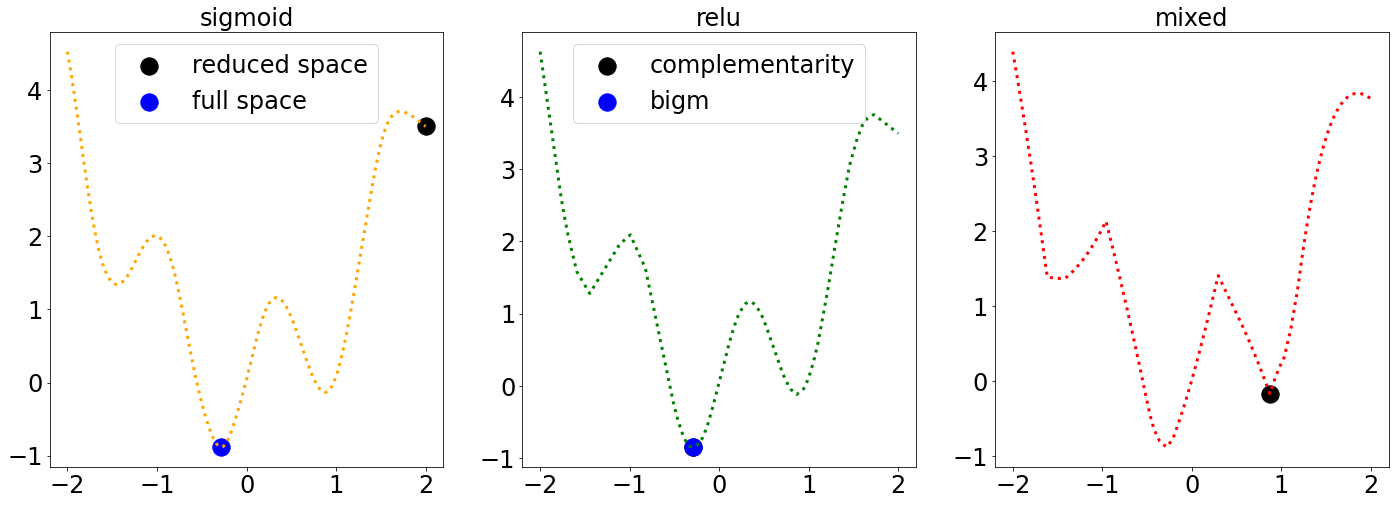

In [32]:
#create a plot with 3 subplots
fig,axs = plt.subplots(1,3,figsize = (24,8))

#nn1 - sigmoid
axs[0].plot(x,y_predict_sigmoid,linewidth = 3.0,linestyle="dotted",color = "orange")
axs[0].set_title("sigmoid")
axs[0].scatter([solution_1_reduced[0]],[solution_1_reduced[1]],color = "black",s = 300, label="reduced space")
axs[0].scatter([solution_1_full[0]],[solution_1_full[1]],color = "blue",s = 300, label="full space")
axs[0].legend()

#nn2 - relu
axs[1].plot(x,y_predict_relu,linewidth = 3.0,linestyle="dotted",color = "green")
axs[1].set_title("relu")
axs[1].scatter([solution_2_comp[0]],[solution_2_comp[1]],color = "black",s = 300, label="complementarity")
axs[1].scatter([solution_2_bigm[0]],[solution_2_bigm[1]],color = "blue",s = 300, label="bigm")
axs[1].legend()

#nn3 - mixed
axs[2].plot(x,y_predict_mixed,linewidth = 3.0,linestyle="dotted", color = "red")
axs[2].set_title("mixed")
axs[2].scatter([solution_3_mixed[0]],[solution_3_mixed[1]],color = "black",s = 300);